In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import scale

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
from torch import autograd

In [2]:
path = "F:\JupyterNotebook_Dir\REAM _Lab\CCPP\CCPP\Folds5x2_pp.xlsx"
data = pd.read_excel(path)



data_AT = data["AT"].values;data_V = data["V"].values
data_AP = data["AP"].values;data_RH = data["RH"];data_PE = data["PE"].values
data=np.vstack((data_AT,data_V,data_AP,data_RH))
data=data.T

#data pre-processing
scaler1 = StandardScaler()
scaler2 = MaxAbsScaler()

data_standard = scaler1.fit_transform(data)
# data_standard = scaler2.fit_transform(data_standard)
#data_PE=data_PE.T
X_train, X_test, y_train, y_test = train_test_split(data_standard, data_PE, test_size=0.33)

# Neural Network

In [3]:
x_all = Variable(torch.from_numpy(data_standard))
y_all = Variable(torch.from_numpy(data_PE))

In [4]:
x_ts=torch.from_numpy(X_train)
y_ts=torch.from_numpy(y_train)
x_test_ts=torch.from_numpy(X_test)
y_test_ts=torch.from_numpy(y_test)
n_train = y_train.shape[0]
n_test = y_test.shape[0]
y_ts=y_ts.reshape(n_train,1)
y_test_ts = y_test_ts.reshape(n_test,1)
x=Variable(x_ts)

In [5]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = torch.nn.Linear(4,8) 
        self.linear2 = torch.nn.Linear(8,6)
        self.predict = torch.nn.Linear(6,1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out =self.predict(out)
        return out
    
model = Model().double()


model

Model(
  (linear1): Linear(in_features=4, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=6, bias=True)
  (predict): Linear(in_features=6, out_features=1, bias=True)
)

In [6]:
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-5)
loss_func = torch.nn.MSELoss()

h_list = []
l_list = []
for epoch in range(3000):
    # forward
    y_pred = model(x)
    loss = loss_func(y_pred,y_ts)
   # print(epoch, loss.item())
    h_list.append(epoch)
    l_list.append(loss.item())
    
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    # updating parameters
    optimizer.step()

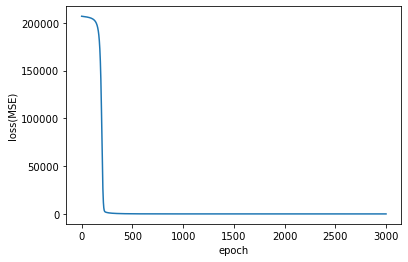

In [7]:
plt.plot(h_list, l_list)
plt.ylabel('loss(MSE)')
plt.xlabel('epoch')
plt.show()

r2_score is 0.920090046730155
MSE is 23.772822656923115


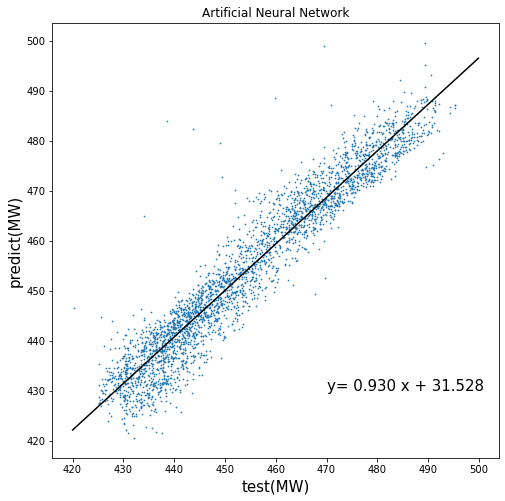

In [8]:
y_test_model=model(x_test_ts)
y_predict=y_test_model.detach().numpy()
plt.figure(figsize=(8,8))
plt.xlabel('test(MW)',fontsize=15)
plt.ylabel('predict(MW)',fontsize=15)
plt.scatter(y_test,y_predict,s=0.5)

z5 = np.polyfit(y_test,y_predict,1)  #Linear fitting
x5 = np.arange(420, 500, 0.1)
y5 = x5 * z5[0]+z5[1]
plt.plot(x5, y5,'black')
z6 = np.polyfit(y_test,y_predict,1)  #Linear fitting
plt.text(470,430,'y= %.3f x + %.3f'%(z6[0],z6[1]),fontsize=15)
plt.title('Artificial Neural Network')
r_ANN=r2_score(y_test,y_predict)
print('r2_score is %s'%r_ANN)
MSE_ANN = mean_squared_error(y_test,y_predict)
print('MSE is %s'%MSE_ANN)

# Train a GAN model

In [9]:
# define the discriminator
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(4, 18), 
            nn.LeakyReLU(0.2),  
            nn.Linear(18, 18),  
            nn.LeakyReLU(0.2),
            nn.Linear(18, 1),
            nn.Sigmoid()  
            
        )
 
    def forward(self, x):
        x = self.dis(x)
        return x

class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(3, 18),  
            nn.ReLU(True),  
            nn.Linear(18, 18),  
            nn.ReLU(True), 
            nn.Linear(18, 18),  
            nn.ReLU(True), 
            nn.Linear(18, 4)
#             nn.Tanh()  
        )
 
    def forward(self, x):
        x = self.gen(x)
        return x


# D = discriminator()
# G = generator()

# FGSM attack

In [10]:
def FGSM_attack(x_test_ts, y_test_ts, level):
    x_test_ts = Variable(x_test_ts,requires_grad=True)
    zero_gradients(x_test_ts)
    y_test_model=model(x_test_ts)
    loss = loss_func(y_test_ts,y_test_model)
    loss.backward()
    normed_grad = level * torch.sign(x_test_ts.grad.data)
    x_adv_ts = x_test_ts.data + normed_grad
    y_adv_ts = model(x_adv_ts)
    return x_adv_ts, y_adv_ts

In [11]:
# levels = np.arange(start=0, stop=0.22, step=0.03)

levels = np.arange(start=0, stop=0.22, step=0.03)

#y_ts=y_ts.reshape(3158,1)

train_scores = []
test_scores = []
test_MAPE = []

pert_level = []

for level in levels:
    x_adv_ts, y_adv_ts = FGSM_attack(x_test_ts,y_test_ts,level)
    y_p1 = y_adv_ts.detach().numpy()    
    r=r2_score(y_test,y_p1)
    test_scores.append(r)
    
    test_error = mean_absolute_percentage_error(y_test,y_p1)*2500
    test_MAPE.append(test_error)
    
    
    pert = mean_absolute_percentage_error(x_test_ts,x_adv_ts)/10
    pert_level.append(pert*100)
    


In [12]:
print(test_MAPE)
print(pert_level)

[20.79382407935848, 24.310313864162506, 27.81280823549489, 31.310418768193706, 34.80526852660186, 38.296457577149106, 41.789527484006264, 45.27983556886682]
[0.0, 2.3885485904121104, 4.777097180824221, 7.165645771236321, 9.554194361648442, 11.942742952060533, 14.331291542472641, 16.719840132884766]


[2079.38240794 2431.03138642 2781.28082355 3131.04187682 3480.52685266
 3829.64575771 4178.9527484  4527.98355689]


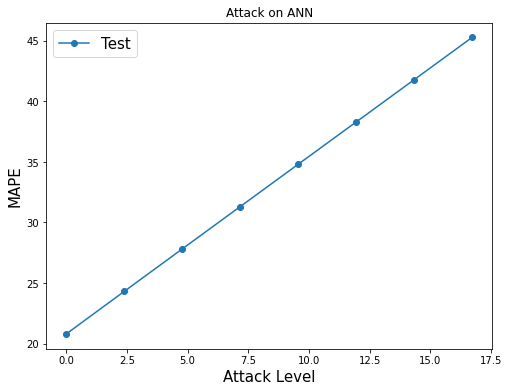

In [13]:
plt.figure(figsize=(8,6))
# plt.plot(levels, train_scores, label="Train",marker='o');
plt.plot(pert_level, np.array(test_MAPE), label="Test",marker='o');
plt.xlabel("Attack Level",fontsize=15);
plt.ylabel("MAPE",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("Attack on ANN")
print(np.array(test_MAPE)*100)

# GAN based denoising

# PCA defense

# Autoencoder

In [14]:
class autoencoder(torch.nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(torch.nn.Linear(4, 8),
                                     torch.nn.ReLU(),
                                     torch.nn.Linear(8, 8),
                                     torch.nn.ReLU(),
                                     torch.nn.Linear(8, 3))
        self.decoder = nn.Sequential(torch.nn.Linear(3, 8),
                                     torch.nn.ReLU(),
                                     torch.nn.Linear(8, 8),
                                     torch.nn.Tanh(),
                                     torch.nn.Linear(8, 4),
                                     torch.nn.Tanh())
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode
                                     
model_ae = autoencoder().double()

# load saved model

In [15]:
class Model_pca(torch.nn.Module):
    def __init__(self):
        super(Model_ReducedDim,self).__init__()
        self.linear1 = torch.nn.Linear(3,12) 
        self.linear2 = torch.nn.Linear(12,8)
        self.predict = torch.nn.Linear(8,1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out =self.predict(out)
        return out

In [16]:
# model_p = torch.load('model_pca')
model_1 = torch.load('model_ae')
model_2 = torch.load('model_ae_defense')

model_GAN = torch.load('G')

In [17]:
testAE_new_scores = []
testGAN_new_scores = []

testAE_new_MAPE = []
testGAN_new_MAPE = []
pca = PCA(n_components=3)

lr = 1e2
loss_func = torch.nn.MSELoss()
dim_noise = 3
num_iter = 1500

for level in levels:

#     x_adv_ts, y_adv_ts = FGSM_attack(x_test_ts,y_test_ts,level)
    x_adv_ts, y_adv_ts = FGSM_attack(x_all,y_all,level)
    
    #     autoencoder
    x_pred = model_1(x_adv_ts)[0]
    y_p1 = model_2(x_pred)
    y_p1 = y_p1.detach().numpy()    
#     r=r2_score(y_test,y_p1)
    r=r2_score(y_all,y_p1)
    testAE_new_scores.append(r)
    
    testAE_new_error = mean_absolute_percentage_error(y_all,y_p1)*2000
    testAE_new_MAPE.append(testAE_new_error)
    
# #     pca
# #     x_adv_ts, y_adv_ts = FGSM_attack(x_test_ts,y_test_ts,level)
# #     pca.fit(x_adv_ts)
# #     pca.fit(x_all)
#     x_te_pca = pca.fit_transform(x_adv_ts)
#     x_te_pca=torch.from_numpy(x_te_pca)
#     y_p1 = model_p(x_te_pca)
#     y_p1 = y_p1.detach().numpy()    
# #     r=r2_score(y_test,y_p1)
#     r=r2_score(y_all,y_p1)
#     testPCA_new_scores.append(r)
    
#     GAN

    z = Variable(torch.randn(y_all.shape[0], dim_noise))  
    # Generate random noise
    z.requires_grad = True
    for i in range(num_iter):
        z.retain_grad()
        x_gen = model_GAN(z)

        loss = loss_func(x_adv_ts,x_gen) 
        loss.backward(retain_graph=True)  
        z = z-lr*z.grad
        
    y_gen_pred = model(x_gen.double())

    r2 = r2_score(y_all.detach().numpy(),y_gen_pred.detach().numpy())
    testGAN_new_scores.append(r2)
    
    testGAN_new_error = mean_absolute_percentage_error(y_all.detach().numpy(),y_gen_pred.detach().numpy())*2000
    testGAN_new_MAPE.append(testGAN_new_error)

F:\Anaconda\envs\python385\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([9568, 1])) that is different to the input size (torch.Size([9568])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
F:\Anaconda\envs\python385\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([9568, 1])) that is different to the input size (torch.Size([9568])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
F:\Anaconda\envs\python385\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([9568, 1])) that is different to the input size (torch.Size([9568])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

In [18]:
model_p = torch.load('model_pca')

testPCA_new_scores = []
testPCA_new_MAPE = []


for level in levels:
    x_adv_ts, y_adv_ts = FGSM_attack(x_test_ts,y_test_ts,level)
    x_adv_ts  = x_adv_ts.detach().numpy()
    pca.fit(x_adv_ts)
    x_te_pca = pca.fit_transform(x_adv_ts)
    x_te_pca=torch.from_numpy(x_te_pca)
    y_p1 = model_p(x_te_pca)
    y_p1 = y_p1.detach().numpy()    
    r=r2_score(y_test,y_p1)
    testPCA_new_scores.append(r)
    
    testPCA_new_error = mean_absolute_percentage_error(y_test,y_p1)*2000
    testPCA_new_MAPE.append(testPCA_new_error)

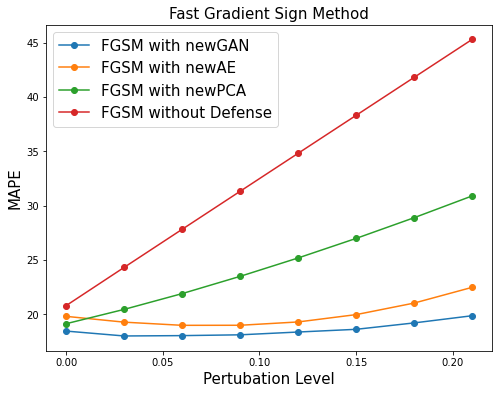

In [19]:

plt.figure(figsize=(8,6))


plt.plot(levels, np.array(testGAN_new_MAPE), label="FGSM with newGAN",marker='o');
plt.plot(levels, np.array(testAE_new_MAPE), label="FGSM with newAE",marker='o');
plt.plot(levels, np.array(testPCA_new_MAPE), label="FGSM with newPCA",marker='o');

plt.plot(levels, np.array(test_MAPE), label="FGSM without Defense",marker='o');
plt.xlabel("Pertubation Level",fontsize=15);
plt.ylabel("MAPE",fontsize=15);
plt.title("Fast Gradient Sign Method",fontsize=15)
plt.legend(prop={'size': 15})


In [20]:
print(levels)
print(testGAN_new_MAPE)
print(testAE_new_MAPE)
print(testPCA_new_MAPE)
print(test_MAPE)

[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21]
[18.443839581929645, 17.993871510201572, 18.02668754512437, 18.099973379820266, 18.357292811811956, 18.606513016962747, 19.195123961812588, 19.855722147278193]
[19.797934667931866, 19.265239204182848, 18.973529321126577, 18.97929523134051, 19.284646088634723, 19.959172008051066, 21.021273564954218, 22.46743533303936]
[19.124672508679495, 20.441954123252827, 21.89403039317698, 23.481432291306177, 25.173499290067074, 26.97281193897991, 28.87603882339942, 30.879328818310007]
[20.79382407935848, 24.310313864162506, 27.81280823549489, 31.310418768193706, 34.80526852660186, 38.296457577149106, 41.789527484006264, 45.27983556886682]


In [21]:
level_new = np.arange(start=0, stop=0.21, step=0.05)
print(level_new)

[0.   0.05 0.1  0.15 0.2 ]


Hey. I tested your level range and it was not that ideal. I think it is because that for different datasets, we used different scalers for preprocessing (min-max, standard scaler, etc.). Even the same scaler like standard scaler, we cannot ensure all the datasets are in the same distribution. So one attack level may not be suitable for the other. I will discuss this at Thursday's meeting